## Dùng GAN và conditional-GAN để sinh ra ảnh fashion-MNIST


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import numpy as np

## GAN

In [10]:


# Kiểm tra sự sẵn có của GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chuẩn bị dữ liệu và DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
batch_size = 32

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Định nghĩa kích thước của vector ngẫu nhiên (latent vector) và số lớp (số loại quần áo trong Fashion-MNIST)
latent_dim = 100
num_classes = 10


In [3]:
# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        x = torch.cat([z, labels], 1)
        x = self.fc(x)
        return x

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(784 + num_classes, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = torch.cat([x, labels], 1)
        x = self.fc(x)
        return x

# Tạo instances của Generator và Discriminator và chuyển chúng đến thiết bị (device)
generator = Generator().to(device)
discriminator = Discriminator().to(device)


In [4]:
# Hàm mất mát cho Generator
criterion_generator = nn.BCELoss()

# Hàm mất mát cho Discriminator
criterion_discriminator = nn.BCELoss()

# Optimizers
optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002)


In [5]:
def save_samples(generator, epoch, latent_dim, num_classes, num_samples=10):
    z = torch.randn(num_samples, latent_dim).to(device)
    labels = torch.randint(0, num_classes, (num_samples,), dtype=torch.long).to(device)
    labels = one_hot_encode(labels, num_classes, device).to(device)
    samples = generator(z, labels)
    samples = samples.view(num_samples, 1, 28, 28)
    samples = (samples + 1) / 2.0
    save_image(samples, f"gan_samples_epoch_{epoch}.png", nrow=num_samples, normalize=True)

def one_hot_encode(labels, num_classes, device):
    # Move labels tensor to the same device as one_hot
    labels = labels.to(device)

    # Reshape labels to match the size of one_hot
    labels = labels.view(-1, 1)

    # Create a one-hot encoding of labels directly on the device
    one_hot = torch.zeros(labels.size(0), num_classes, device=device)
    one_hot.scatter_(1, labels, 1)
    return one_hot




In [10]:


num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (real_images, real_labels) in enumerate(train_loader):
        real_images = real_images.view(-1, 784).to(device)
        real_labels = one_hot_encode(real_labels, num_classes, device)  # Remove the .to(device)

        # Tạo tensors ones và zeros để làm ground truth cho Discriminator
        ones = torch.ones(batch_size, 1).to(device)
        zeros = torch.zeros(batch_size, 1).to(device)

        # Huấn luyện Discriminator
        optimizer_discriminator.zero_grad()
        outputs = discriminator(real_images, real_labels)
        loss_real = criterion_discriminator(outputs, ones)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (batch_size,), dtype=torch.long).to(device)
        fake_labels = one_hot_encode(fake_labels, num_classes, device)  # Remove the .to(device)
        fake_images = generator(z, fake_labels)
        outputs = discriminator(fake_images, fake_labels)
        loss_fake = criterion_discriminator(outputs, zeros)

        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Huấn luyện Generator
        optimizer_generator.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (batch_size,), dtype=torch.long).to(device)
        fake_labels = one_hot_encode(fake_labels, num_classes, device)  # Remove the .to(device)
        fake_images = generator(z, fake_labels)
        outputs = discriminator(fake_images, fake_labels)
        loss_generator = criterion_generator(outputs, ones)
        loss_generator.backward()
        optimizer_generator.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss D: {loss_discriminator.item()}, Loss G: {loss_generator.item()}")

    if (epoch + 1) % 10 == 0:
        save_samples(generator, epoch + 1, latent_dim, num_classes)


Epoch [10/10], Loss D: 0.78846275806427, Loss G: 2.63523268699646


In [13]:
# Lưu các mẫu mỗi một số epochs
save_samples(generator, num_epochs, latent_dim, num_classes)

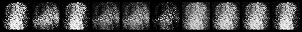

In [14]:
from IPython.display import Image

# Hiển thị ảnh đã tạo từ GAN
Image("gan_samples_epoch_10.png")


## c-GAN

In [24]:
# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(num_classes, num_classes)
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        embedded_labels = self.embed(labels)
        x = torch.cat([z, embedded_labels], 1)
        x = self.fc(x)
        return x

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(num_classes, num_classes)
        self.fc = nn.Sequential(
            nn.Linear(784 + num_classes, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        embedded_labels = self.embed(labels)
        x = torch.cat([x, embedded_labels], 1)
        x = self.fc(x)
        return x

# Tạo instances của Generator và Discriminator và chuyển chúng đến thiết bị (device)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Hàm mất mát cho Generator
criterion_generator = nn.BCELoss()

# Hàm mất mát cho Discriminator
criterion_discriminator = nn.BCELoss()

# Optimizers
optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002)

def save_samples(generator, epoch, latent_dim, num_classes, num_samples=10):
    z = torch.randn(num_samples, latent_dim).to(device)
    labels = torch.randint(0, num_classes, (num_samples,), dtype=torch.long).to(device)
    samples = generator(z, labels)
    samples = samples.view(num_samples, 1, 28, 28)
    samples = (samples + 1) / 2.0
    save_image(samples, f"cgan_samples_epoch_{epoch}.png", nrow=num_samples, normalize=True)

# Lưu các mẫu mỗi một số epochs
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (real_images, real_labels) in enumerate(train_loader):
        real_images = real_images.view(-1, 784).to(device)
        real_labels = real_labels.to(device)

        # Tạo tensors ones và zeros để làm ground truth cho Discriminator
        ones = torch.ones(batch_size, 1).to(device)
        zeros = torch.zeros(batch_size, 1).to(device)

        # Huấn luyện Discriminator
        optimizer_discriminator.zero_grad()
        outputs = discriminator(real_images, real_labels)
        loss_real = criterion_discriminator(outputs, ones)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (batch_size,), dtype=torch.long).to(device)
        fake_images = generator(z, fake_labels)
        outputs = discriminator(fake_images, fake_labels)
        loss_fake = criterion_discriminator(outputs, zeros)

        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Huấn luyện Generator
        optimizer_generator.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (batch_size,), dtype=torch.long).to(device)
        fake_images = generator(z, fake_labels)
        outputs = discriminator(fake_images, fake_labels)
        loss_generator = criterion_generator(outputs, ones)
        loss_generator.backward()
        optimizer_generator.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss D: {loss_discriminator.item()}, Loss G: {loss_generator.item()}")

    if (epoch + 1) % 10 == 0:
        save_samples(generator, epoch + 1, latent_dim, num_classes)

# Lưu các mẫu mỗi một số epochs
save_samples(generator, num_epochs, latent_dim, num_classes)

Epoch [10/10], Loss D: 0.7240902185440063, Loss G: 2.4025473594665527


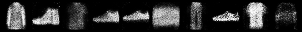

In [27]:

Image("cgan_samples_epoch_10.png")